# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

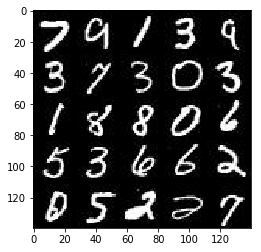

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

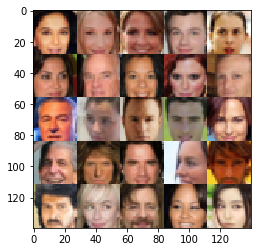

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(
        tf.float32,
        [None, image_width, image_height, image_channels],
        name='real_input'
    )
    z_input = tf.placeholder(
        tf.float32,
        [None, z_dim],
        name='z_input'
    )
    learning_rate = tf.placeholder(
        tf.float32, [], name='learning_rate'
    )
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = .2
    chn = 32

    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, chn, 4, strides=2, padding='same')
        l1 = tf.layers.batch_normalization(l1, training=True)
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d(l1, chn << 1, 4, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)
        
        l3 = tf.layers.conv2d(l2, chn << 2, 4, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha * l3, l3)
        
        flat = tf.reshape(l3, (-1, 4 * 4 * chn << 2))
        logits = tf.layers.dense(flat, 1)
        dis_output = tf.sigmoid(logits)

    
    return dis_output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = .2
    chn = 32
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        l1 = tf.layers.dense(z, 4 * 4 * chn << 3)
        l1 = tf.reshape(l1, [-1, 4, 4, chn << 3])
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d_transpose(l1, chn << 2, 4, 1, 'valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)

        l3 = tf.layers.conv2d_transpose(l2, chn << 1, 5, 2, 'same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        
        logits = tf.layers.conv2d_transpose(
            l3, out_channel_dim, 5, 2, 'same'
        )
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    reuse = True
    
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=reuse)

    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real, labels=tf.ones_like(dis_model_real)
        )
    )
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)
        
        ))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)
        )
    )

    dis_loss = dis_loss_real + dis_loss_fake

    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()

    d_vars = [i for i in t_vars if i.name.startswith('discriminator')]
    g_vars = [i for i in t_vars if i.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    d_updates = [i for i in update_ops if i.name.startswith('discriminator')]
    g_updates = [i for i in update_ops if i.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _learning_rate = learning_rate
    render_step = 150
    log_step = 20
    steps = 0
    widths, heights, chns = data_shape[1], data_shape[2], data_shape[3]

    input_real, input_z, learning_rate = model_inputs(
        widths, heights, chns, z_dim
    )
    
    d_loss, g_loss = model_loss(input_real, input_z, chns)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                batch_images *= 2.
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z,
                    learning_rate: _learning_rate,
                }
                sess.run(d_opt, feed_dict=feed_dict)
                sess.run(g_opt, feed_dict=feed_dict)

                steps += 1
                if steps % log_step == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print(
                        "Epoch {}/{} Step {}...".format(epoch_i + 1, epoch_count, steps),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )

                if steps % render_step == 0:
                    show_generator_output(sess, 25, input_z, chns, data_image_mode)

        show_generator_output(sess, 25, input_z, chns, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 20... Discriminator Loss: 1.0003... Generator Loss: 0.8833
Epoch 1/2 Step 40... Discriminator Loss: 0.8231... Generator Loss: 0.9291
Epoch 1/2 Step 60... Discriminator Loss: 0.8138... Generator Loss: 1.4380
Epoch 1/2 Step 80... Discriminator Loss: 1.2435... Generator Loss: 1.0058
Epoch 1/2 Step 100... Discriminator Loss: 0.8293... Generator Loss: 1.2200
Epoch 1/2 Step 120... Discriminator Loss: 0.9302... Generator Loss: 1.1118
Epoch 1/2 Step 140... Discriminator Loss: 0.8004... Generator Loss: 1.0899


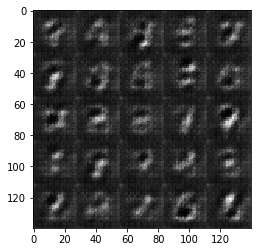

Epoch 1/2 Step 160... Discriminator Loss: 0.8041... Generator Loss: 1.3341
Epoch 1/2 Step 180... Discriminator Loss: 1.0418... Generator Loss: 0.9427
Epoch 1/2 Step 200... Discriminator Loss: 0.9751... Generator Loss: 1.7367
Epoch 1/2 Step 220... Discriminator Loss: 1.0566... Generator Loss: 1.0137
Epoch 1/2 Step 240... Discriminator Loss: 1.1150... Generator Loss: 1.1420
Epoch 1/2 Step 260... Discriminator Loss: 0.8735... Generator Loss: 1.7803
Epoch 1/2 Step 280... Discriminator Loss: 0.8808... Generator Loss: 0.9139
Epoch 1/2 Step 300... Discriminator Loss: 1.0088... Generator Loss: 0.7193


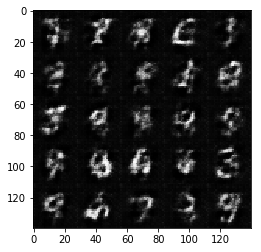

Epoch 1/2 Step 320... Discriminator Loss: 1.1505... Generator Loss: 0.5269
Epoch 1/2 Step 340... Discriminator Loss: 0.8301... Generator Loss: 0.9609
Epoch 1/2 Step 360... Discriminator Loss: 0.9148... Generator Loss: 0.8596
Epoch 1/2 Step 380... Discriminator Loss: 1.0305... Generator Loss: 0.5894
Epoch 1/2 Step 400... Discriminator Loss: 1.2461... Generator Loss: 0.4216
Epoch 1/2 Step 420... Discriminator Loss: 0.9128... Generator Loss: 0.7082
Epoch 1/2 Step 440... Discriminator Loss: 0.8519... Generator Loss: 1.4463


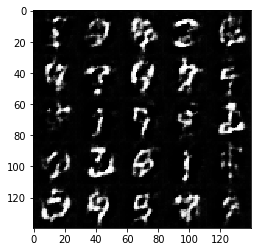

Epoch 1/2 Step 460... Discriminator Loss: 0.9878... Generator Loss: 0.6736
Epoch 1/2 Step 480... Discriminator Loss: 0.8340... Generator Loss: 0.8474
Epoch 1/2 Step 500... Discriminator Loss: 1.1292... Generator Loss: 2.2520
Epoch 1/2 Step 520... Discriminator Loss: 0.9896... Generator Loss: 0.6006
Epoch 1/2 Step 540... Discriminator Loss: 0.8915... Generator Loss: 0.8077
Epoch 1/2 Step 560... Discriminator Loss: 1.0926... Generator Loss: 0.5742
Epoch 1/2 Step 580... Discriminator Loss: 0.8069... Generator Loss: 1.4470
Epoch 1/2 Step 600... Discriminator Loss: 0.7511... Generator Loss: 0.8858


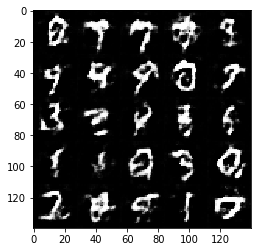

Epoch 1/2 Step 620... Discriminator Loss: 1.0405... Generator Loss: 0.5890
Epoch 1/2 Step 640... Discriminator Loss: 0.8496... Generator Loss: 0.8931
Epoch 1/2 Step 660... Discriminator Loss: 1.0224... Generator Loss: 1.6092
Epoch 1/2 Step 680... Discriminator Loss: 0.8924... Generator Loss: 0.8381
Epoch 1/2 Step 700... Discriminator Loss: 0.9109... Generator Loss: 0.9938
Epoch 1/2 Step 720... Discriminator Loss: 0.9797... Generator Loss: 1.4409
Epoch 1/2 Step 740... Discriminator Loss: 0.9557... Generator Loss: 0.7372


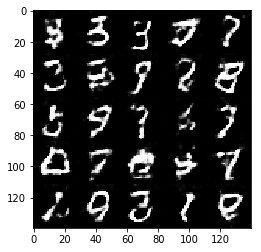

Epoch 1/2 Step 760... Discriminator Loss: 0.9185... Generator Loss: 1.7332
Epoch 1/2 Step 780... Discriminator Loss: 0.8207... Generator Loss: 1.2739
Epoch 1/2 Step 800... Discriminator Loss: 0.9438... Generator Loss: 1.0832
Epoch 1/2 Step 820... Discriminator Loss: 0.8215... Generator Loss: 0.9667
Epoch 1/2 Step 840... Discriminator Loss: 1.0721... Generator Loss: 0.5429
Epoch 1/2 Step 860... Discriminator Loss: 0.8465... Generator Loss: 1.5823
Epoch 1/2 Step 880... Discriminator Loss: 0.9680... Generator Loss: 1.6322
Epoch 1/2 Step 900... Discriminator Loss: 1.1549... Generator Loss: 0.5299


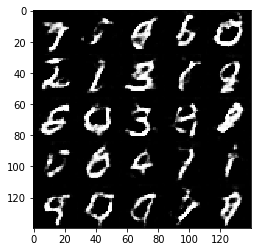

Epoch 1/2 Step 920... Discriminator Loss: 0.8430... Generator Loss: 0.7754
Epoch 2/2 Step 940... Discriminator Loss: 0.9141... Generator Loss: 0.8363
Epoch 2/2 Step 960... Discriminator Loss: 0.8466... Generator Loss: 1.2838
Epoch 2/2 Step 980... Discriminator Loss: 0.7541... Generator Loss: 1.0641
Epoch 2/2 Step 1000... Discriminator Loss: 0.7928... Generator Loss: 1.4531
Epoch 2/2 Step 1020... Discriminator Loss: 0.7370... Generator Loss: 1.1407
Epoch 2/2 Step 1040... Discriminator Loss: 1.1056... Generator Loss: 0.5326


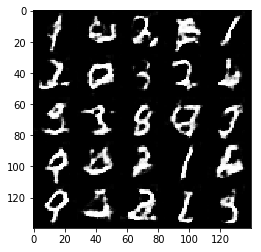

Epoch 2/2 Step 1060... Discriminator Loss: 0.9508... Generator Loss: 0.6942
Epoch 2/2 Step 1080... Discriminator Loss: 1.6543... Generator Loss: 0.2788
Epoch 2/2 Step 1100... Discriminator Loss: 0.7859... Generator Loss: 1.0815
Epoch 2/2 Step 1120... Discriminator Loss: 0.7588... Generator Loss: 1.6509
Epoch 2/2 Step 1140... Discriminator Loss: 0.7320... Generator Loss: 1.2732
Epoch 2/2 Step 1160... Discriminator Loss: 0.6950... Generator Loss: 1.0867
Epoch 2/2 Step 1180... Discriminator Loss: 0.7206... Generator Loss: 1.1138
Epoch 2/2 Step 1200... Discriminator Loss: 0.7278... Generator Loss: 1.0240


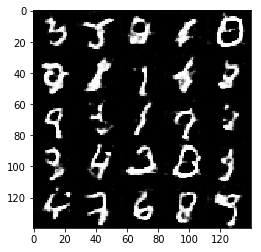

Epoch 2/2 Step 1220... Discriminator Loss: 0.9308... Generator Loss: 0.7178
Epoch 2/2 Step 1240... Discriminator Loss: 0.7709... Generator Loss: 0.9308
Epoch 2/2 Step 1260... Discriminator Loss: 0.6734... Generator Loss: 1.6264
Epoch 2/2 Step 1280... Discriminator Loss: 0.7479... Generator Loss: 1.1789
Epoch 2/2 Step 1300... Discriminator Loss: 1.3111... Generator Loss: 0.4111
Epoch 2/2 Step 1320... Discriminator Loss: 0.7770... Generator Loss: 1.1807
Epoch 2/2 Step 1340... Discriminator Loss: 1.1970... Generator Loss: 2.0860


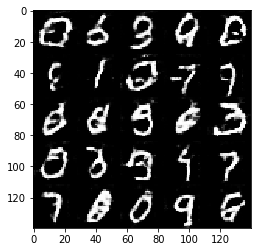

Epoch 2/2 Step 1360... Discriminator Loss: 0.7831... Generator Loss: 0.8683
Epoch 2/2 Step 1380... Discriminator Loss: 1.0779... Generator Loss: 0.5320
Epoch 2/2 Step 1400... Discriminator Loss: 0.8031... Generator Loss: 0.8953
Epoch 2/2 Step 1420... Discriminator Loss: 0.6165... Generator Loss: 1.5186
Epoch 2/2 Step 1440... Discriminator Loss: 1.2243... Generator Loss: 0.5603
Epoch 2/2 Step 1460... Discriminator Loss: 0.6512... Generator Loss: 1.2366
Epoch 2/2 Step 1480... Discriminator Loss: 0.6553... Generator Loss: 1.0879
Epoch 2/2 Step 1500... Discriminator Loss: 0.6424... Generator Loss: 1.7586


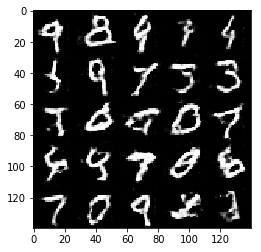

Epoch 2/2 Step 1520... Discriminator Loss: 1.2769... Generator Loss: 0.4013
Epoch 2/2 Step 1540... Discriminator Loss: 0.7132... Generator Loss: 1.0449
Epoch 2/2 Step 1560... Discriminator Loss: 0.7111... Generator Loss: 0.9665
Epoch 2/2 Step 1580... Discriminator Loss: 0.8103... Generator Loss: 0.9564
Epoch 2/2 Step 1600... Discriminator Loss: 0.7044... Generator Loss: 0.9409
Epoch 2/2 Step 1620... Discriminator Loss: 0.8250... Generator Loss: 0.8489
Epoch 2/2 Step 1640... Discriminator Loss: 0.7161... Generator Loss: 0.9618


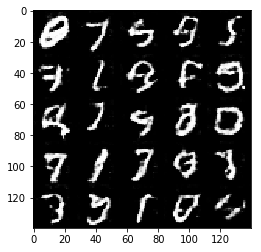

Epoch 2/2 Step 1660... Discriminator Loss: 0.9444... Generator Loss: 1.5462
Epoch 2/2 Step 1680... Discriminator Loss: 0.7549... Generator Loss: 2.1751
Epoch 2/2 Step 1700... Discriminator Loss: 0.5444... Generator Loss: 1.5433
Epoch 2/2 Step 1720... Discriminator Loss: 0.7306... Generator Loss: 1.0882
Epoch 2/2 Step 1740... Discriminator Loss: 0.7978... Generator Loss: 2.1626
Epoch 2/2 Step 1760... Discriminator Loss: 0.6230... Generator Loss: 1.5080
Epoch 2/2 Step 1780... Discriminator Loss: 0.7385... Generator Loss: 1.0346
Epoch 2/2 Step 1800... Discriminator Loss: 0.7780... Generator Loss: 0.9837


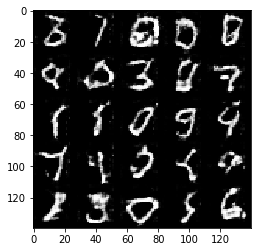

Epoch 2/2 Step 1820... Discriminator Loss: 1.0262... Generator Loss: 0.6254
Epoch 2/2 Step 1840... Discriminator Loss: 0.8335... Generator Loss: 0.8235
Epoch 2/2 Step 1860... Discriminator Loss: 0.9605... Generator Loss: 0.6286


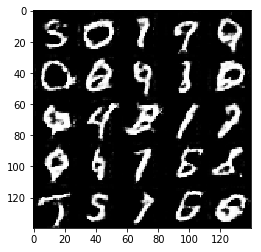

In [16]:
batch_size = 64
z_dim = 100
learning_rate = .00025
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 20... Discriminator Loss: 1.5967... Generator Loss: 0.4477
Epoch 1/1 Step 40... Discriminator Loss: 1.3230... Generator Loss: 0.7928
Epoch 1/1 Step 60... Discriminator Loss: 0.5438... Generator Loss: 1.5105
Epoch 1/1 Step 80... Discriminator Loss: 0.6969... Generator Loss: 1.1942
Epoch 1/1 Step 100... Discriminator Loss: 0.4756... Generator Loss: 1.6012
Epoch 1/1 Step 120... Discriminator Loss: 0.3455... Generator Loss: 1.7968
Epoch 1/1 Step 140... Discriminator Loss: 0.3429... Generator Loss: 2.4760


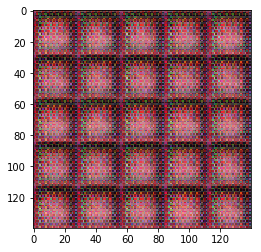

Epoch 1/1 Step 160... Discriminator Loss: 0.8602... Generator Loss: 4.0804
Epoch 1/1 Step 180... Discriminator Loss: 0.3281... Generator Loss: 2.4834
Epoch 1/1 Step 200... Discriminator Loss: 0.3417... Generator Loss: 2.0386
Epoch 1/1 Step 220... Discriminator Loss: 0.5779... Generator Loss: 1.2953
Epoch 1/1 Step 240... Discriminator Loss: 0.3314... Generator Loss: 1.7960
Epoch 1/1 Step 260... Discriminator Loss: 0.4007... Generator Loss: 2.1350
Epoch 1/1 Step 280... Discriminator Loss: 0.3239... Generator Loss: 1.5944
Epoch 1/1 Step 300... Discriminator Loss: 0.5246... Generator Loss: 1.1862


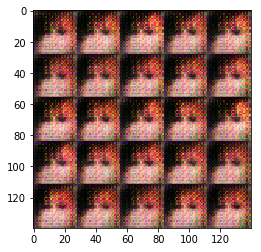

Epoch 1/1 Step 320... Discriminator Loss: 0.2134... Generator Loss: 2.2895
Epoch 1/1 Step 340... Discriminator Loss: 0.2907... Generator Loss: 2.1061
Epoch 1/1 Step 360... Discriminator Loss: 0.2063... Generator Loss: 2.7055
Epoch 1/1 Step 380... Discriminator Loss: 0.1593... Generator Loss: 2.4486
Epoch 1/1 Step 400... Discriminator Loss: 0.0789... Generator Loss: 3.1111
Epoch 1/1 Step 420... Discriminator Loss: 0.0991... Generator Loss: 2.6624
Epoch 1/1 Step 440... Discriminator Loss: 0.1145... Generator Loss: 3.0037


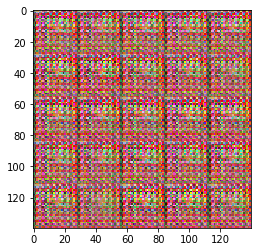

Epoch 1/1 Step 460... Discriminator Loss: 0.1389... Generator Loss: 3.0472
Epoch 1/1 Step 480... Discriminator Loss: 0.0688... Generator Loss: 3.1100
Epoch 1/1 Step 500... Discriminator Loss: 0.0869... Generator Loss: 3.2432
Epoch 1/1 Step 520... Discriminator Loss: 0.0762... Generator Loss: 3.2771
Epoch 1/1 Step 540... Discriminator Loss: 0.1015... Generator Loss: 3.1786
Epoch 1/1 Step 560... Discriminator Loss: 0.2319... Generator Loss: 2.6199
Epoch 1/1 Step 580... Discriminator Loss: 0.1509... Generator Loss: 3.3382
Epoch 1/1 Step 600... Discriminator Loss: 0.3190... Generator Loss: 2.3989


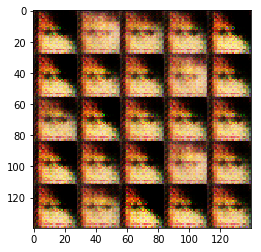

Epoch 1/1 Step 620... Discriminator Loss: 0.4869... Generator Loss: 1.2960
Epoch 1/1 Step 640... Discriminator Loss: 0.7583... Generator Loss: 0.8853
Epoch 1/1 Step 660... Discriminator Loss: 0.6622... Generator Loss: 1.1983
Epoch 1/1 Step 680... Discriminator Loss: 1.1209... Generator Loss: 0.7937
Epoch 1/1 Step 700... Discriminator Loss: 0.8025... Generator Loss: 2.1046
Epoch 1/1 Step 720... Discriminator Loss: 0.6005... Generator Loss: 1.4862
Epoch 1/1 Step 740... Discriminator Loss: 0.8624... Generator Loss: 1.5058


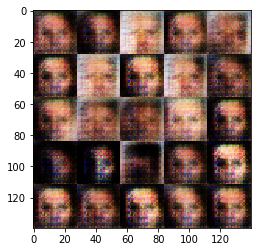

Epoch 1/1 Step 760... Discriminator Loss: 0.7930... Generator Loss: 1.1926
Epoch 1/1 Step 780... Discriminator Loss: 1.1120... Generator Loss: 1.0557
Epoch 1/1 Step 800... Discriminator Loss: 1.0742... Generator Loss: 0.6849
Epoch 1/1 Step 820... Discriminator Loss: 1.0916... Generator Loss: 1.7056
Epoch 1/1 Step 840... Discriminator Loss: 1.0087... Generator Loss: 1.3571
Epoch 1/1 Step 860... Discriminator Loss: 0.8048... Generator Loss: 1.0661
Epoch 1/1 Step 880... Discriminator Loss: 0.9515... Generator Loss: 0.7790
Epoch 1/1 Step 900... Discriminator Loss: 0.8405... Generator Loss: 1.1510


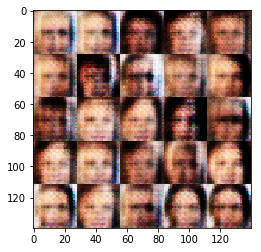

Epoch 1/1 Step 920... Discriminator Loss: 0.7498... Generator Loss: 1.5064
Epoch 1/1 Step 940... Discriminator Loss: 1.0966... Generator Loss: 2.0204
Epoch 1/1 Step 960... Discriminator Loss: 1.0088... Generator Loss: 1.5629
Epoch 1/1 Step 980... Discriminator Loss: 0.9398... Generator Loss: 1.7033
Epoch 1/1 Step 1000... Discriminator Loss: 1.0835... Generator Loss: 1.0945
Epoch 1/1 Step 1020... Discriminator Loss: 1.1012... Generator Loss: 0.9699
Epoch 1/1 Step 1040... Discriminator Loss: 0.8798... Generator Loss: 1.0537


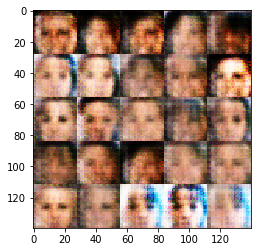

Epoch 1/1 Step 1060... Discriminator Loss: 0.8691... Generator Loss: 1.0507
Epoch 1/1 Step 1080... Discriminator Loss: 1.2074... Generator Loss: 0.9446
Epoch 1/1 Step 1100... Discriminator Loss: 1.0828... Generator Loss: 1.0625
Epoch 1/1 Step 1120... Discriminator Loss: 0.9543... Generator Loss: 1.2038
Epoch 1/1 Step 1140... Discriminator Loss: 0.8783... Generator Loss: 1.1140
Epoch 1/1 Step 1160... Discriminator Loss: 1.0793... Generator Loss: 1.1371
Epoch 1/1 Step 1180... Discriminator Loss: 0.9409... Generator Loss: 0.9290
Epoch 1/1 Step 1200... Discriminator Loss: 1.3481... Generator Loss: 0.7525


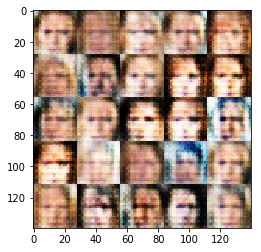

Epoch 1/1 Step 1220... Discriminator Loss: 1.0371... Generator Loss: 1.0421
Epoch 1/1 Step 1240... Discriminator Loss: 1.3384... Generator Loss: 0.7753
Epoch 1/1 Step 1260... Discriminator Loss: 1.2657... Generator Loss: 0.7641
Epoch 1/1 Step 1280... Discriminator Loss: 0.8627... Generator Loss: 1.2270
Epoch 1/1 Step 1300... Discriminator Loss: 1.0905... Generator Loss: 1.1024
Epoch 1/1 Step 1320... Discriminator Loss: 1.1573... Generator Loss: 1.0500
Epoch 1/1 Step 1340... Discriminator Loss: 0.9864... Generator Loss: 1.1255


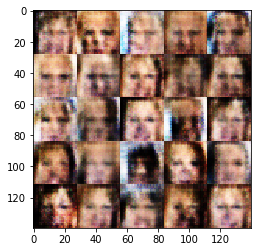

Epoch 1/1 Step 1360... Discriminator Loss: 1.4672... Generator Loss: 0.4974
Epoch 1/1 Step 1380... Discriminator Loss: 1.0234... Generator Loss: 1.2006
Epoch 1/1 Step 1400... Discriminator Loss: 1.3264... Generator Loss: 0.7865
Epoch 1/1 Step 1420... Discriminator Loss: 1.3043... Generator Loss: 0.8042
Epoch 1/1 Step 1440... Discriminator Loss: 1.3346... Generator Loss: 0.6806
Epoch 1/1 Step 1460... Discriminator Loss: 1.2075... Generator Loss: 0.8792
Epoch 1/1 Step 1480... Discriminator Loss: 1.3940... Generator Loss: 0.5615
Epoch 1/1 Step 1500... Discriminator Loss: 1.0776... Generator Loss: 0.8629


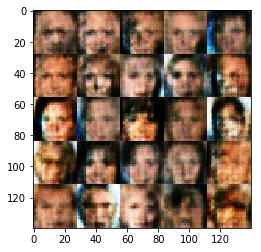

Epoch 1/1 Step 1520... Discriminator Loss: 1.3483... Generator Loss: 0.8824
Epoch 1/1 Step 1540... Discriminator Loss: 1.2142... Generator Loss: 1.2023
Epoch 1/1 Step 1560... Discriminator Loss: 1.1212... Generator Loss: 0.9390
Epoch 1/1 Step 1580... Discriminator Loss: 1.1681... Generator Loss: 1.0797
Epoch 1/1 Step 1600... Discriminator Loss: 1.0379... Generator Loss: 0.8538
Epoch 1/1 Step 1620... Discriminator Loss: 1.1620... Generator Loss: 0.8668
Epoch 1/1 Step 1640... Discriminator Loss: 1.1961... Generator Loss: 0.9998


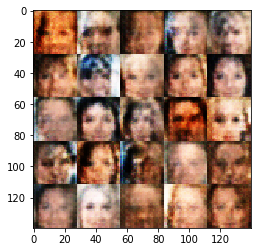

Epoch 1/1 Step 1660... Discriminator Loss: 1.1989... Generator Loss: 0.8686
Epoch 1/1 Step 1680... Discriminator Loss: 1.1089... Generator Loss: 0.9795
Epoch 1/1 Step 1700... Discriminator Loss: 1.1905... Generator Loss: 0.7934
Epoch 1/1 Step 1720... Discriminator Loss: 1.2677... Generator Loss: 0.8195
Epoch 1/1 Step 1740... Discriminator Loss: 1.2435... Generator Loss: 0.8591
Epoch 1/1 Step 1760... Discriminator Loss: 1.2267... Generator Loss: 0.7522
Epoch 1/1 Step 1780... Discriminator Loss: 1.4924... Generator Loss: 0.5579
Epoch 1/1 Step 1800... Discriminator Loss: 1.3598... Generator Loss: 0.7605


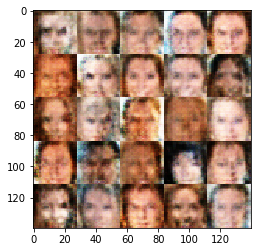

Epoch 1/1 Step 1820... Discriminator Loss: 1.1002... Generator Loss: 0.9638
Epoch 1/1 Step 1840... Discriminator Loss: 1.2147... Generator Loss: 0.9876
Epoch 1/1 Step 1860... Discriminator Loss: 1.2996... Generator Loss: 0.9017
Epoch 1/1 Step 1880... Discriminator Loss: 1.2373... Generator Loss: 0.8038
Epoch 1/1 Step 1900... Discriminator Loss: 1.4191... Generator Loss: 0.6357
Epoch 1/1 Step 1920... Discriminator Loss: 1.1173... Generator Loss: 0.9406
Epoch 1/1 Step 1940... Discriminator Loss: 1.1272... Generator Loss: 1.0035


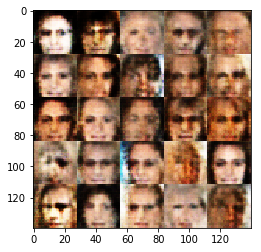

Epoch 1/1 Step 1960... Discriminator Loss: 1.1873... Generator Loss: 0.9072
Epoch 1/1 Step 1980... Discriminator Loss: 1.0660... Generator Loss: 0.8610
Epoch 1/1 Step 2000... Discriminator Loss: 1.5411... Generator Loss: 0.9380
Epoch 1/1 Step 2020... Discriminator Loss: 1.3392... Generator Loss: 0.5892
Epoch 1/1 Step 2040... Discriminator Loss: 1.4057... Generator Loss: 0.6501
Epoch 1/1 Step 2060... Discriminator Loss: 1.1112... Generator Loss: 0.8521
Epoch 1/1 Step 2080... Discriminator Loss: 1.5906... Generator Loss: 0.5447
Epoch 1/1 Step 2100... Discriminator Loss: 1.3367... Generator Loss: 0.6785


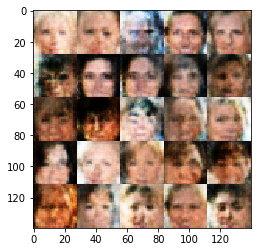

Epoch 1/1 Step 2120... Discriminator Loss: 1.1772... Generator Loss: 0.8765
Epoch 1/1 Step 2140... Discriminator Loss: 1.3979... Generator Loss: 0.6568
Epoch 1/1 Step 2160... Discriminator Loss: 1.4252... Generator Loss: 0.6260
Epoch 1/1 Step 2180... Discriminator Loss: 1.2367... Generator Loss: 0.8568
Epoch 1/1 Step 2200... Discriminator Loss: 1.3233... Generator Loss: 0.6533
Epoch 1/1 Step 2220... Discriminator Loss: 1.2873... Generator Loss: 0.7499
Epoch 1/1 Step 2240... Discriminator Loss: 1.2828... Generator Loss: 0.8098


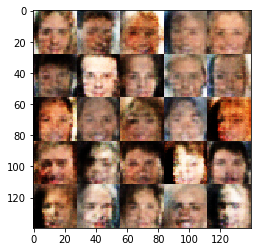

Epoch 1/1 Step 2260... Discriminator Loss: 1.3020... Generator Loss: 0.7286
Epoch 1/1 Step 2280... Discriminator Loss: 1.3980... Generator Loss: 0.7273
Epoch 1/1 Step 2300... Discriminator Loss: 1.4858... Generator Loss: 0.5106
Epoch 1/1 Step 2320... Discriminator Loss: 1.2931... Generator Loss: 0.6945
Epoch 1/1 Step 2340... Discriminator Loss: 1.2612... Generator Loss: 0.7255
Epoch 1/1 Step 2360... Discriminator Loss: 1.2238... Generator Loss: 0.8053
Epoch 1/1 Step 2380... Discriminator Loss: 1.1476... Generator Loss: 1.1618
Epoch 1/1 Step 2400... Discriminator Loss: 1.2458... Generator Loss: 0.7788


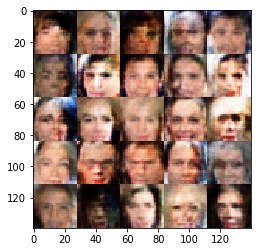

Epoch 1/1 Step 2420... Discriminator Loss: 1.1715... Generator Loss: 0.6887
Epoch 1/1 Step 2440... Discriminator Loss: 1.3214... Generator Loss: 0.7324
Epoch 1/1 Step 2460... Discriminator Loss: 1.1574... Generator Loss: 0.9463
Epoch 1/1 Step 2480... Discriminator Loss: 1.0745... Generator Loss: 0.8827
Epoch 1/1 Step 2500... Discriminator Loss: 1.1797... Generator Loss: 0.8777
Epoch 1/1 Step 2520... Discriminator Loss: 1.2784... Generator Loss: 0.8903
Epoch 1/1 Step 2540... Discriminator Loss: 1.1578... Generator Loss: 0.7151


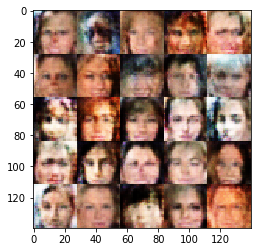

Epoch 1/1 Step 2560... Discriminator Loss: 1.1997... Generator Loss: 0.6806
Epoch 1/1 Step 2580... Discriminator Loss: 1.3724... Generator Loss: 0.7094
Epoch 1/1 Step 2600... Discriminator Loss: 1.3777... Generator Loss: 0.8645
Epoch 1/1 Step 2620... Discriminator Loss: 1.3715... Generator Loss: 0.5174
Epoch 1/1 Step 2640... Discriminator Loss: 1.1137... Generator Loss: 0.8636
Epoch 1/1 Step 2660... Discriminator Loss: 1.0935... Generator Loss: 0.8635
Epoch 1/1 Step 2680... Discriminator Loss: 1.1605... Generator Loss: 0.7789
Epoch 1/1 Step 2700... Discriminator Loss: 1.4676... Generator Loss: 0.8024


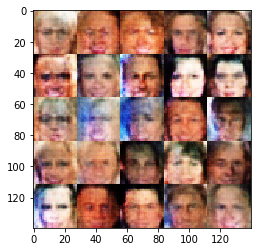

Epoch 1/1 Step 2720... Discriminator Loss: 1.1269... Generator Loss: 0.8045
Epoch 1/1 Step 2740... Discriminator Loss: 1.2855... Generator Loss: 0.6543
Epoch 1/1 Step 2760... Discriminator Loss: 1.2150... Generator Loss: 0.7992
Epoch 1/1 Step 2780... Discriminator Loss: 1.2752... Generator Loss: 0.7275
Epoch 1/1 Step 2800... Discriminator Loss: 1.3192... Generator Loss: 0.7156
Epoch 1/1 Step 2820... Discriminator Loss: 1.2285... Generator Loss: 0.6940
Epoch 1/1 Step 2840... Discriminator Loss: 1.2962... Generator Loss: 0.7894


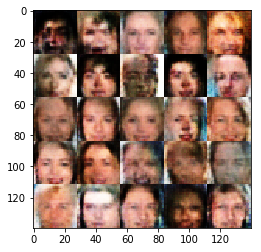

Epoch 1/1 Step 2860... Discriminator Loss: 1.2831... Generator Loss: 0.6193
Epoch 1/1 Step 2880... Discriminator Loss: 1.4949... Generator Loss: 0.5876
Epoch 1/1 Step 2900... Discriminator Loss: 1.1821... Generator Loss: 0.7678
Epoch 1/1 Step 2920... Discriminator Loss: 1.0954... Generator Loss: 0.7793
Epoch 1/1 Step 2940... Discriminator Loss: 1.3186... Generator Loss: 0.7925
Epoch 1/1 Step 2960... Discriminator Loss: 1.3224... Generator Loss: 0.6117
Epoch 1/1 Step 2980... Discriminator Loss: 1.3354... Generator Loss: 0.8467
Epoch 1/1 Step 3000... Discriminator Loss: 1.2404... Generator Loss: 0.7229


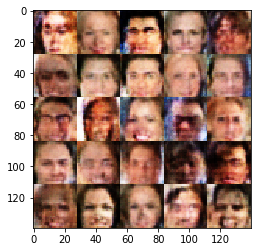

Epoch 1/1 Step 3020... Discriminator Loss: 1.3556... Generator Loss: 0.5992
Epoch 1/1 Step 3040... Discriminator Loss: 1.1931... Generator Loss: 0.7307
Epoch 1/1 Step 3060... Discriminator Loss: 1.1802... Generator Loss: 1.0117
Epoch 1/1 Step 3080... Discriminator Loss: 1.4127... Generator Loss: 0.7327
Epoch 1/1 Step 3100... Discriminator Loss: 1.2959... Generator Loss: 0.7276
Epoch 1/1 Step 3120... Discriminator Loss: 1.0538... Generator Loss: 0.8369
Epoch 1/1 Step 3140... Discriminator Loss: 1.2864... Generator Loss: 0.5738


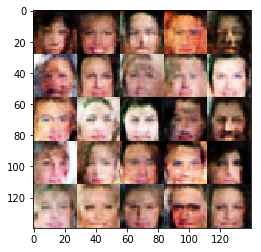

Epoch 1/1 Step 3160... Discriminator Loss: 1.4573... Generator Loss: 0.4900


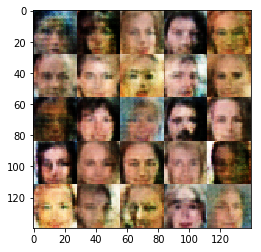

In [17]:
batch_size = 64
z_dim = 100
learning_rate = .0003
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.